In [1]:
import numpy as np
import scipy 
import h5py 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
from math import *
from utils import *

from torch.utils.data import Dataset, DataLoader


Get the first point in the dataset

In [29]:
training = pd.read_csv('train.csv')
first_instance = training.iloc[3]
pts, c, s = first_instance['part'], first_instance['center'], first_instance['scale']

# s = s * 200
c = np.fromstring(c.replace('[', '').replace(']', '').replace('\n', ''), sep=' ').reshape(2)
pts = np.fromstring(pts.replace('[', '').replace(']', '').replace('\n', ''), sep=' ').reshape(-1, 2)
img_path = first_instance['image_path']

In [30]:
s, c, img_path

(3.7069707309338176, array([147., 250.]), './images/048884658.jpg')

In [31]:
maxScale = 0.25 
maxRotate = 30
r = 0

# Adjust center/scale slightly to avoid cropping limbs
if c[0] != -1:
    c[1] = c[1] + 15 * s
    s = s * 1.25

s = s * 200
def Rnd(x):
	wow = torch.randn(1)
	return max(-2 * x, min(2 * x, float(wow) * x))

# s = s * (2 ** Rnd(maxScale))
# r = 0 if np.random.random() < 0.6 else Rnd(maxRotate)
s = s
r = 0

print(s, r, c)

926.7426827334544 0 [147.         305.60456096]


In [32]:
pts

array([[  0.,   0.],
       [  0.,   0.],
       [ 48., 417.],
       [129., 357.],
       [  0.,   0.],
       [  0.,   0.],
       [ 89., 387.],
       [150., 196.],
       [154., 192.],
       [247., 110.],
       [362., 363.],
       [240., 350.],
       [148., 214.],
       [151., 177.],
       [166., 308.],
       [184., 326.]])

(480, 852, 3)


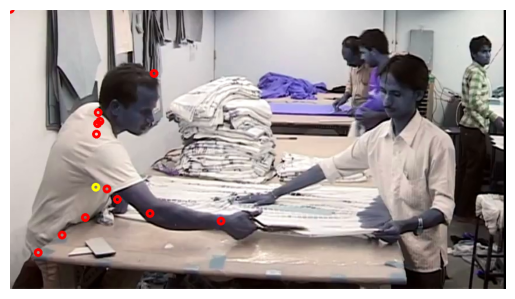

(480, 852, 3)


In [33]:
img = cv2.imread(img_path)
print(img.shape)
c_x, c_y = int(c[0]), int(c[1])

new_img = img.copy()
img_bonus = cv2.circle(new_img, (c_x, c_y), 5, (255, 255, 0), 3)

for i in range(16):
    x, y = int(pts[i][0]), int(pts[i][1])
    img_bonus = cv2.circle(new_img, (x, y), 5, (255, 0, 0), 3)

plt.imshow(img_bonus)
plt.axis('off')
plt.show()

print(img.shape)

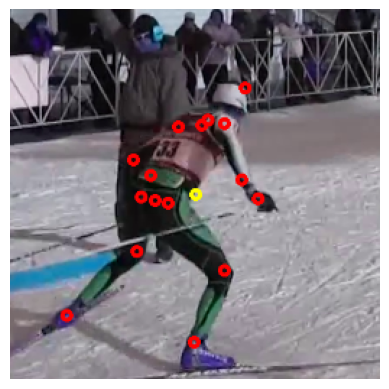

In [7]:
inputRes = 256

inp = Crop(img_bonus, c, s, r, inputRes) / 256

plt.imshow(np.transpose(inp, (1, 2, 0)))
plt.axis('off')
plt.show()

In [8]:
outputRes = 32
numJoints = 16
hmGauss = 1

pts_new = pts.copy()
out = np.zeros((numJoints, outputRes, outputRes))
for i in range(numJoints):
    pts_new[i] = Transform(pts[i], c, s, r, outputRes)
    out[i] = DrawGaussian(out[i], pts_new[i], hmGauss, 0.5 if outputRes == 32 else -1)
print(pts_new)

[[15. 28.]
 [18. 22.]
 [13. 16.]
 [11. 16.]
 [10. 20.]
 [ 4. 26.]
 [12. 16.]
 [16.  9.]
 [17.  9.]
 [20.  6.]
 [21. 16.]
 [19. 14.]
 [18.  9.]
 [14. 10.]
 [10. 12.]
 [12. 14.]]


In [9]:
pts_new = pts_new * 256 / 32
pts_new

array([[120., 224.],
       [144., 176.],
       [104., 128.],
       [ 88., 128.],
       [ 80., 160.],
       [ 32., 208.],
       [ 96., 128.],
       [128.,  72.],
       [136.,  72.],
       [160.,  48.],
       [168., 128.],
       [152., 112.],
       [144.,  72.],
       [112.,  80.],
       [ 80.,  96.],
       [ 96., 112.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


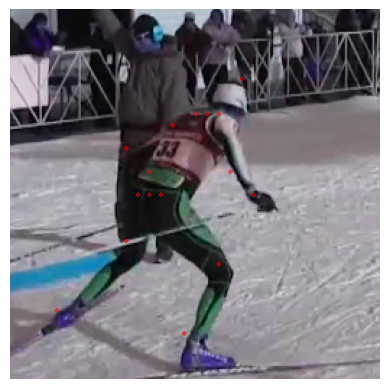

In [10]:
inputRes = 256

original_inp = Crop(img, c, s, r, inputRes) / 256
original_inp = np.transpose(original_inp, (1, 2, 0))

for i in range(16):
    x, y = int(pts_new[i][0]), int(pts_new[i][1])
    img_bonus = cv2.circle(original_inp, (x, y), 1, (255, 0, 0), 1)


plt.imshow(original_inp)
plt.axis('off')
plt.show()

In [11]:
print(out.shape)

(16, 32, 32)


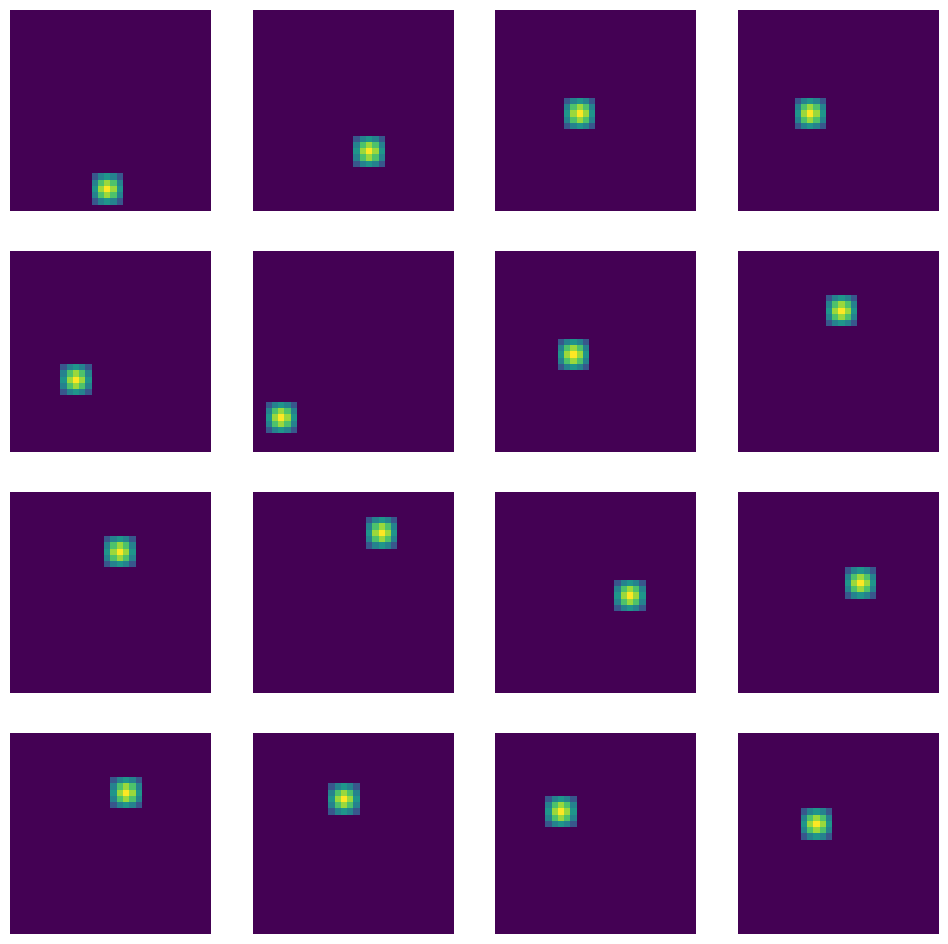

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(out[i][np.newaxis], (1, 2, 0)))
    ax.axis('off')
plt.show()

In [13]:
print(out[0][-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
from utils import *
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
from math import *

from torch.utils.data import Dataset, DataLoader

class MPII(Dataset):
    def __init__(self, split, inputRes, outputRes, maxScale = 0.25, 
                 maxRotate = 30, hmGauss = 1):
        
        annotation_file = None
        self.split = split
        self.maxScale = maxScale
        self.maxRotate = maxRotate
        self.hmGauss = hmGauss
        
        self.inputRes = inputRes
        self.outputRes = outputRes
        self.nJoints = 16
        
        if self.split == 'train':
            annotation_file = 'train.csv'
        elif self.split == 'valid':
            annotation_file = 'valid.csv'
        elif self.split == 'test':
            annotation_file = 'test.csv'

        self.annotation = pd.read_csv(annotation_file)

    def __len__(self):
        return self.annotation.shape[0]

    def getElement(self, instance):
        imgPath = instance['image_path']
        pts = instance['part']
        c = instance['center']
        s = instance['scale']

        pts = np.fromstring(pts.replace('[', '').replace(']', '').replace('\n', ''), sep=' ').reshape(-1, 2)
        c = np.fromstring(c.replace('[', '').replace(']', '').replace('\n', ''), sep=' ').reshape(2)
        
        if c[0] != -1:
            c[1] = c[1] + 15 * s
            s = s * 1.25

        s = s * 200
        
        return imgPath, pts, c, s

    def plot_image(self, idx, color = (255, 0, 0)):
        instance = self.annotation.iloc[idx]
        img_path, pts, c, s = self.getElement(instance)

        # print(s, c)
        r = 0
        
        img = cv2.imread(img_path)

        inp = Crop(img, c, s, r, self.inputRes) / 256
        inp = np.transpose(inp, (1, 2, 0))
        
            
        # out = np.zeros((self.nJoints, self.outputRes, self.outputRes))
        
        if (self.split == 'train' or self.split == 'val'):
            for i in range(self.nJoints):
                pts[i] = Transform(pts[i], c, s, r, self.outputRes)             
                pts[i] = pts[i] * 256 / 32 +

                x, y = int(pts[i][0]), int(pts[i][1])
                cv2.circle(inp, (x, y), 2, color= color, thickness = 2)
                
            plt.imshow(inp)
            plt.axis('off')
            plt.show()
    
        else: 
            print("Only Training and Valid set")
    
    def __getitem__(self, idx):
        
        instance = self.annotation.iloc[idx]
        img_path, pts, c, s = self.getElement(instance)

        r = 0
        
        img = cv2.imread(img_path)
        inp = Crop(img, c, s, r, self.inputRes) / 256
        
        out = np.zeros((self.nJoints, self.outputRes, self.outputRes))
        
        if (self.split == 'train' or self.split == 'val'):
            for i in range(self.nJoints):
                pts[i] = Transform(pts[i], c, s, r, self.outputRes)             
                out[i] = DrawGaussian(out[i], pts[i], self.hmGauss, 
                                      0.5 if outputRes == 32 else -1)

        
        return inp, pts, out

In [35]:
inputRes = 256
outputRes = 32

train_dataset = MPII(split = 'train', inputRes = inputRes, outputRes = outputRes)


inp, pts, out = train_dataset[0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


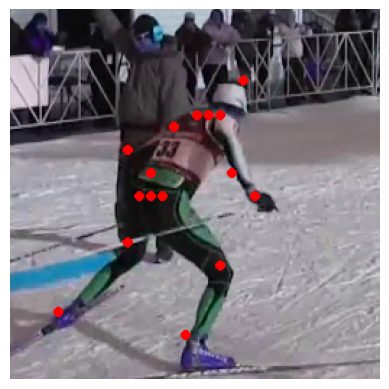

In [37]:
train_dataset.plot_image(0)

In [22]:
head = pts[9]
neck = pts[10] 

print(head)
print(neck)

cal = np.linalg.norm(neck - head)
print(cal * 0.5)

[20.  6.]
[21. 16.]
5.024937810560445


In [23]:
head_up = head * 256 / 32 + (256 /32) /2
neck_up = neck * 256 / 32 + (256 /32) /2

head_up, neck_up
cal = np.linalg.norm(neck_up - head_up)
print(cal * 0.5)

40.19950248448356
